Import thư viện và đọc file benchmark và các tool

In [37]:
import pandas as pd
import itertools
import math

benchmark = pd.read_csv('../data/owasp/expected_results_320.csv')
benchmark = benchmark.rename(columns=lambda x: x.strip())
benchmark = benchmark.rename(columns={'# test name': 'TestCase', 'real vulnerability': 'Expected', 'category': 'CWE'})
benchmark['TestCase'] = benchmark['TestCase'].str.strip()
benchmark['CWE'] = benchmark['CWE'].str.lower()
benchmark = benchmark.drop(['Benchmark version: 1.2', '2016-06-1'], axis=1)

tools = {
    'semgrep': '../data/semgrep/semgrep_results_format.csv',
    'sonarqube': '../data/sonarqube/sonarqube_results_format.csv',
    'zap': '../data/zap/zap_results_format.csv',
    'arachni': '../data/arachni/arachni_results_format.csv',
    'fsb': '../data/fsb/fsb_results_format.csv'
}

# Gộp Detected từ từng tool vào benchmark
for tool, path in tools.items():
    df_tool = pd.read_csv(path)
    df_tool = df_tool[['TestCase', 'CWE', 'Detected']].rename(columns={'Detected': f'Detected_{tool}'})
    benchmark = benchmark.merge(df_tool, on=['TestCase', 'CWE'], how='left')

benchmark.fillna(False, inplace=True)
detected_cols = [col for col in benchmark.columns if col.startswith('Detected_')]

Hàm tính chỉ số

In [38]:
def calc_metrics(TP, FP, FN, TN):
    rec = TP / (TP + FN) if TP + FN else 0.0
    prec = TP / (TP + FP) if TP + FP else 0.0
    fpr = FP / (FP + TN) if FP + TN else 0.0
    fbeta = lambda b: (1 + b**2) * prec * rec / (b**2 * prec + rec) if (prec + rec) else 0.0
    f1, f05, f15 = fbeta(1), fbeta(0.5), fbeta(1.5)
    denom = math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    mark = ((TP * TN) - (FP * FN)) / denom if denom else 0.0
    inf = rec - fpr
    return [rec, fpr, prec, f1, f05, f15, mark, inf]

Hàm tổ hợp và tính toán

In [39]:
results = []
results2 = []

for n in [1, 2, 3]:
    for combo in itertools.combinations(tools.keys(), n):
        col_names = [f'Detected_{t}' for t in combo]
        combo_name = ' + '.join(combo)
        
        # Áp dụng 1ooN logic
        def eval_row(row):
            expected = row['Expected']
            detected = [row[col] for col in col_names]
            if expected:
                return 'TP' if any(detected) else 'FN'
            else:
                return 'FP' if any(detected) else 'TN'
        
        temp_df = benchmark.copy()
        temp_df['Eval'] = temp_df.apply(eval_row, axis=1)
        summary = temp_df['Eval'].value_counts().reindex(['TP', 'FP', 'FN', 'TN'], fill_value=0)
        metrics = calc_metrics(summary['TP'], summary['FP'], summary['FN'], summary['TN'])
        
        results.append([combo_name] + metrics)
        results2.append([combo_name, summary['FP'], summary['FN'], summary['TN'], summary['TP']])

# Xuất kết quả dạng bảng
df_results = pd.DataFrame(results2, columns=['Tool', 'FP', 'FN', 'TN', 'TP'])
display(df_results)

,Tool,FP,FN,TN,TP
0,semgrep,77,59,83,101
1,sonarqube,0,130,160,30
2,zap,0,126,160,34
3,arachni,1,112,159,48
4,fsb,84,13,76,147
5,semgrep + sonarqube,77,39,83,121
6,semgrep + zap,77,53,83,107
7,semgrep + arachni,78,44,82,116
8,semgrep + fsb,99,3,61,157
9,sonarqube + zap,0,96,160,64


Tạo DataFrame kết quả và xuất

In [40]:
columns = ['Combination', 'Rec', 'FPR', 'Prec', 'F1', 'F0.5', 'F1.5', 'Mark', 'Inf']
result_df = pd.DataFrame(results, columns=columns)
result_df.to_csv('../data/combined/combined_tools_metrics.csv', index=False)
result_df.sort_values(by='Rec', ascending=False, inplace=True)
result_df.reset_index(drop=True, inplace=True)
result_df

,Combination,Rec,FPR,Prec,F1,F0.5,F1.5,Mark,Inf
0,semgrep + fsb,0.98125,0.61875,0.613281,0.754808,0.663007,0.828328,0.453125,0.36250
1,semgrep + arachni + fsb,0.98125,0.61875,0.613281,0.754808,0.663007,0.828328,0.453125,0.36250
2,semgrep + sonarqube + fsb,0.98125,0.61875,0.613281,0.754808,0.663007,0.828328,0.453125,0.36250
3,semgrep + zap + fsb,0.98125,0.61875,0.613281,0.754808,0.663007,0.828328,0.453125,0.36250
4,fsb,0.91875,0.52500,0.636364,0.751918,0.678044,0.808376,0.439379,0.39375
5,sonarqube + fsb,0.91875,0.52500,0.636364,0.751918,0.678044,0.808376,0.439379,0.39375
6,arachni + fsb,0.91875,0.52500,0.636364,0.751918,0.678044,0.808376,0.439379,0.39375
7,zap + fsb,0.91875,0.52500,0.636364,0.751918,0.678044,0.808376,0.439379,0.39375
8,sonarqube + zap + fsb,0.91875,0.52500,0.636364,0.751918,0.678044,0.808376,0.439379,0.39375
9,sonarqube + arachni + fsb,0.91875,0.52500,0.636364,0.751918,0.678044,0.808376,0.439379,0.39375


Vẽ biểu đồ kết quả

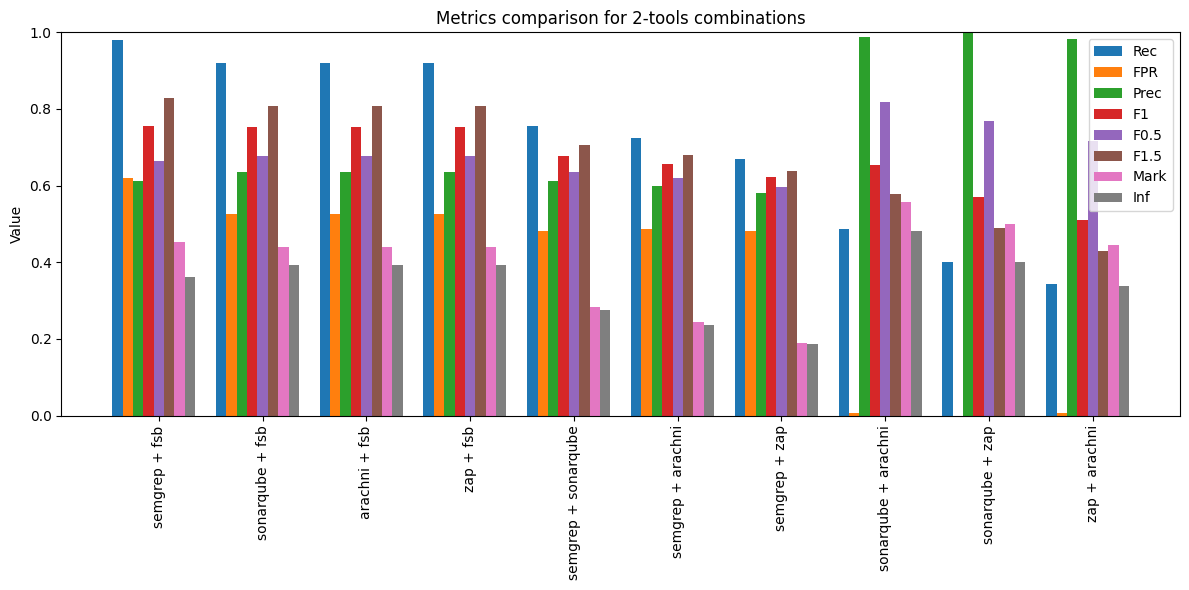

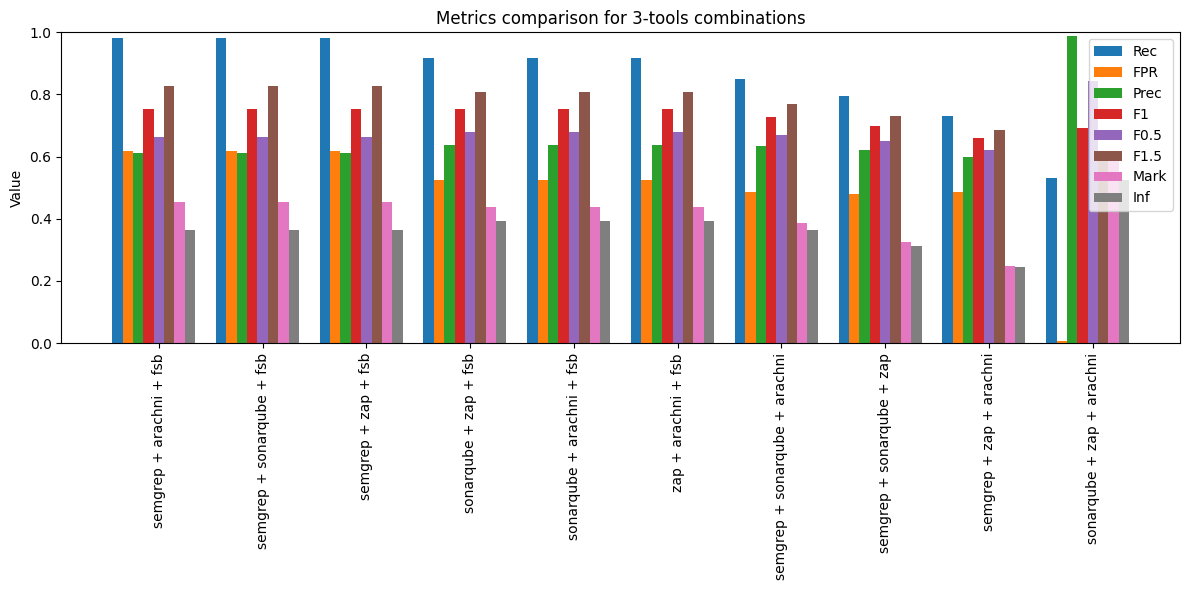

In [41]:
# 1. Tách data 2-tools và 3-tools
result_2tools = result_df[result_df['Combination'].str.count(r'\+')==1]  # 2-tools: chứa đúng 1 dấu '+'
result_3tools = result_df[result_df['Combination'].str.count(r'\+')==2]  # 3-tools: chứa đúng 2 dấu '+'

# 2. Vẽ biểu đồ cho 2-tools
plt.figure(figsize=(12,6))
labels = result_df.columns[1:]  # Các chỉ số (Rec, FPR, Prec, F1, F0.5, F1.5, Mark, Inf)
for i,metric in enumerate(labels):
    plt.bar([x+i*0.1 for x in range(len(result_2tools))], result_2tools[metric], width=0.1, label=metric)
plt.xticks([x+0.4 for x in range(len(result_2tools))], result_2tools['Combination'], rotation=90)
plt.title('Metrics comparison for 2-tools combinations')
plt.ylabel('Value')
plt.ylim(0,1)
plt.legend()
plt.tight_layout()
plt.show()

# 3. Vẽ biểu đồ cho 3-tools
plt.figure(figsize=(12,6))
for i,metric in enumerate(labels):
    plt.bar([x+i*0.1 for x in range(len(result_3tools))], result_3tools[metric], width=0.1, label=metric)
plt.xticks([x+0.4 for x in range(len(result_3tools))], result_3tools['Combination'], rotation=90)
plt.title('Metrics comparison for 3-tools combinations')
plt.ylabel('Value')
plt.ylim(0,1)
plt.legend()
plt.tight_layout()
plt.show()

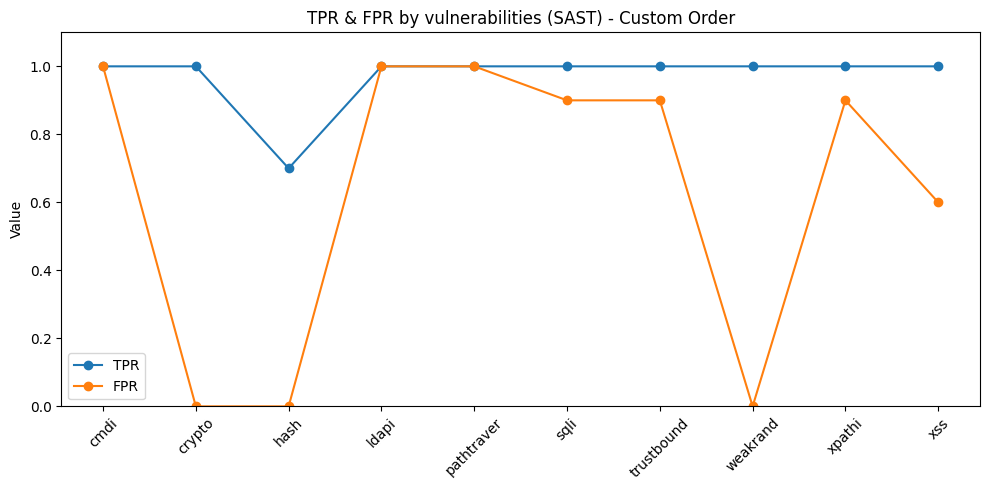

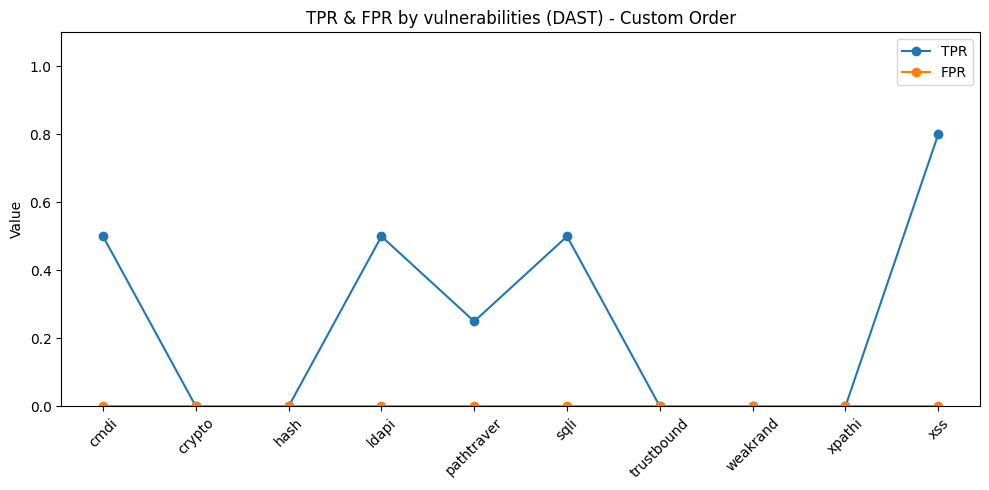

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Phân nhóm tool
sast_cols = ['Detected_semgrep', 'Detected_fsb', 'Detected_sonarqube']
dast_cols = ['Detected_zap', 'Detected_arachni']

# Hàm tính TPR/FPR trung bình theo CWE và nhóm tool
def calc_avg_by_cwe(group_name, cols):
    avg_results = []
    for cwe in benchmark['CWE'].unique():
        sub = benchmark[benchmark['CWE'] == cwe].copy()
        sub['Detected'] = sub[cols].any(axis=1)
        TP = len(sub[(sub['Expected']) & (sub['Detected'])])
        FN = len(sub[(sub['Expected']) & (~sub['Detected'])])
        FP = len(sub[(~sub['Expected']) & (sub['Detected'])])
        TN = len(sub[(~sub['Expected']) & (~sub['Detected'])])
        rec = TP / (TP + FN) if TP + FN else 0.0
        fpr = FP / (FP + TN) if FP + TN else 0.0
        avg_results.append([cwe, rec, fpr, group_name])
    return pd.DataFrame(avg_results, columns=['CWE', 'TPR', 'FPR', 'Group'])

# Tính toán và kết hợp dữ liệu
sast_df = calc_avg_by_cwe('SAST', sast_cols)
dast_df = calc_avg_by_cwe('DAST', dast_cols)

# Đặt thứ tự hiển thị CWE
custom_order = ['cmdi', 'crypto', 'hash', 'ldapi', 'pathtraver', 'sqli', 'trustbound', 'weakrand', 'xpathi', 'xss']
sast_df = sast_df.set_index('CWE').reindex(custom_order).reset_index()
dast_df = dast_df.set_index('CWE').reindex(custom_order).reset_index()

# Vẽ biểu đồ TPR & FPR cho SAST
plt.figure(figsize=(10, 5))
plt.plot(sast_df['CWE'], sast_df['TPR'], marker='o', label='TPR')
plt.plot(sast_df['CWE'], sast_df['FPR'], marker='o', label='FPR')
plt.title('TPR & FPR by vulnerabilities (SAST)')
plt.xticks(rotation=45)
plt.ylim(0, 1.1)
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

# Vẽ biểu đồ TPR & FPR cho DAST
plt.figure(figsize=(10, 5))
plt.plot(dast_df['CWE'], dast_df['TPR'], marker='o', label='TPR')
plt.plot(dast_df['CWE'], dast_df['FPR'], marker='o', label='FPR')
plt.title('TPR & FPR by vulnerabilities (DAST)')
plt.xticks(rotation=45)
plt.ylim(0, 1.1)
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()
